In [97]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
import argparse
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier

!gdown 1Xyxt1Z4rsswxh3iRPGQcYZDDnDOrHQKR
!gdown 16rEm1ZvxTGv_2SxM6SEep3QbIelqYzmP

Downloading...
From: https://drive.google.com/uc?id=1Xyxt1Z4rsswxh3iRPGQcYZDDnDOrHQKR
To: /content/Customer_train.csv
100% 96.8k/96.8k [00:00<00:00, 65.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=16rEm1ZvxTGv_2SxM6SEep3QbIelqYzmP
To: /content/Customer_test.csv
100% 37.9k/37.9k [00:00<00:00, 55.6MB/s]


In [98]:
train_df = pd.read_csv('Customer_train.csv')
test_df = pd.read_csv('Customer_test.csv')

# Fill missing values in training data
num_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
train_df[num_cols] = train_df[num_cols].fillna(train_df[num_cols].median())

cat_cols = train_df.select_dtypes(include=['object']).columns
for col in cat_cols:
    train_df[col] = train_df[col].fillna(train_df[col].mode()[0])

# Separate features and target from training data
X_train = train_df.drop(['ID', 'Segmentation'], axis=1)
y_train = train_df['Segmentation']

# Normalize numerical features in training data
normalizer = Normalizer()
numerical_features = X_train.select_dtypes(include=[np.number]).columns
X_train[numerical_features] = normalizer.fit_transform(X_train[numerical_features])

# Convert categorical variables in training data using LabelEncoder
label_encoders = {}
for column in X_train.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_train[column] = le.fit_transform(X_train[column])
    label_encoders[column] = le

# Fill missing values in test data
num_cols_test = test_df.select_dtypes(include=['float64', 'int64']).columns
test_df[num_cols_test] = test_df[num_cols_test].fillna(test_df[num_cols_test].median())

cat_cols_test = test_df.select_dtypes(include=['object']).columns
for col in cat_cols_test:
    test_df[col] = test_df[col].fillna(test_df[col].mode()[0])

# Separate features from test data
X_test = test_df.drop(['ID'], axis=1)

# Normalize numerical features in test data
X_test[numerical_features] = normalizer.transform(X_test[numerical_features])

# Convert categorical variables in test data using the saved LabelEncoders
for column in X_test.select_dtypes(include=['object']).columns:
    if column in label_encoders:
        X_test[column] = label_encoders[column].transform(X_test[column])


In [99]:
# Train One-vs-One Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
# Predict labels on the test data using rf
y_pred_rf = rf_classifier.predict(X_test)
# Add predictions to the test DataFrame
test_df['Predicted_Segmentation_RF'] = y_pred_rf

In [100]:
# y_pred_rf

In [101]:
import numpy as np
from collections import Counter
from sklearn.tree import DecisionTreeClassifier

class Random_Forest_Classifier:
    def __init__(self,
                 n_estimators=100,
                 criterion="gini",
                 max_depth=None,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 max_features="sqrt",
                 bootstrap=True,
                 oob_score=False,
                 random_state=42):
        """
        Initializes the Random Forest classifier.

        Parameters:
        -----------
        n_estimators : int, default=100
            The number of trees in the forest.

        criterion : {"gini", "entropy"}, default="gini"
            The function to measure the quality of a split.

        max_depth : int, default=None
            The maximum depth of the tree.

        min_samples_split : int, default=2
            The minimum number of samples required to split an internal node.

        min_samples_leaf : int, default=1
            The minimum number of samples required to be at a leaf node.

        max_features : {"sqrt", "log2"}, default="sqrt"
            The number of features to consider when looking for the best split.

        bootstrap : bool, default=True
            Whether bootstrap samples are used when building trees.

        oob_score : bool, default=False
            Whether to use out-of-bag samples to estimate the generalization error.

        random_state : int, default=42
            Controls the randomness of the estimator.

        """
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.oob_score = oob_score
        self.random_state = random_state
        self.estimators = []

    def fit(self, X, y):
        """
        Fits the Random Forest classifier.

        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            The training input samples.

        y : array-like, shape (n_samples,)
            The target values (class labels).
        """
        np.random.seed(self.random_state)
        n_samples = X.shape[0]

        # Train each decision tree on a bootstrap sample of the dataset
        for _ in range(self.n_estimators):
            if self.bootstrap:
                indices = np.random.choice(n_samples, n_samples, replace=True)
            else:
                indices = np.arange(n_samples)

            X_subset, y_subset = X[indices], y[indices]
            tree = DecisionTreeClassifier(
                criterion=self.criterion,
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                max_features=self.max_features,
                random_state=self.random_state
            )
            tree.fit(X_subset, y_subset)
            self.estimators.append(tree)

        # Calculate out-of-bag score if needed
        if self.oob_score and self.bootstrap:
            self._calculate_oob_score(X, y)

    def _calculate_oob_score(self, X, y):
        """
        Calculates the out-of-bag (OOB) score using the OOB samples.

        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            The input data.

        y : array-like, shape (n_samples,)
            The true labels.

        """
        oob_votes = np.zeros((X.shape[0], len(np.unique(y))))
        n_samples = X.shape[0]

        # For each tree, collect votes from its OOB samples
        for i, tree in enumerate(self.estimators):
            bootstrap_indices = np.random.choice(n_samples, n_samples, replace=True)
            oob_indices = np.setdiff1d(np.arange(n_samples), bootstrap_indices)

            if len(oob_indices) > 0:
                oob_predictions = tree.predict(X[oob_indices])
                oob_votes[oob_indices, oob_predictions] += 1

        # Get the majority vote from the OOB samples
        majority_vote = np.argmax(oob_votes, axis=1)
        self.oob_score_ = np.mean(majority_vote == y)

    def predict(self, X):
        """
        Predicts the class labels for the input samples X.

        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            The input samples.

        Returns:
        --------
        y_pred : array, shape (n_samples,)
            The predicted class labels.
        """
        predictions = np.array([tree.predict(X) for tree in self.estimators])

        # Perform majority vote across all trees
        majority_vote = []
        for sample_predictions in predictions.T:
            counts = Counter(sample_predictions)
            majority_vote.append(counts.most_common(1)[0][0])
        return np.array(majority_vote)


In [102]:
# import numpy as np
# from collections import Counter
# from sklearn.tree import DecisionTreeClassifier

# class Random_Forest_Classifier:
#     def __init__(self,
#                  n_estimators=100,
#                  criterion="gini",
#                  max_depth=None,
#                  min_samples_split=2,
#                  min_samples_leaf=1,
#                  min_weight_fraction_leaf=0.0,
#                  max_features="sqrt",
#                  max_leaf_nodes=None,
#                  min_impurity_decrease=0.0,
#                  bootstrap=True,
#                  oob_score=False,
#                  n_jobs=None,
#                  random_state=None,
#                  verbose=0,
#                  warm_start=False,
#                  class_weight=None,
#                  ccp_alpha=0.0,
#                  max_samples=None):
#         """
#         Initializes the Random Forest classifier with advanced configurations.

#         Parameters:
#         -----------
#         n_estimators : int, default=100
#             The number of trees in the forest.

#         criterion : {"gini", "entropy"}, default="gini"
#             The function to measure the quality of a split.

#         max_depth : int, default=None
#             The maximum depth of the tree.

#         min_samples_split : int, default=2
#             The minimum number of samples required to split an internal node.

#         min_samples_leaf : int, default=1
#             The minimum number of samples required to be at a leaf node.

#         min_weight_fraction_leaf : float, default=0.0
#             The minimum weighted fraction of the sum total of weights required to be at a leaf node.

#         max_features : {"sqrt", "log2", None}, default="sqrt"
#             The number of features to consider when looking for the best split.

#         max_leaf_nodes : int, default=None
#             Grow trees with max_leaf_nodes in best-first fashion.

#         min_impurity_decrease : float, default=0.0
#             A node will be split if this split induces a decrease of the impurity greater than or equal to this value.

#         bootstrap : bool, default=True
#             Whether bootstrap samples are used when building trees.

#         oob_score : bool, default=False
#             Whether to use out-of-bag samples to estimate the generalization error.

#         n_jobs : int, default=None
#             The number of jobs to run in parallel.

#         random_state : int, default=None
#             Controls the randomness of the estimator.

#         verbose : int, default=0
#             Controls the verbosity when fitting and predicting.

#         warm_start : bool, default=False
#             Reuse the solution of the previous call to fit and add more estimators.

#         class_weight : dict, list of dicts, "balanced", or "balanced_subsample", default=None
#             Weights associated with classes.

#         ccp_alpha : float, default=0.0
#             Complexity parameter used for Minimal Cost-Complexity Pruning.

#         max_samples : int or float, default=None
#             If bootstrap is True, the number of samples to draw from X to train each base estimator.

#         """
#         self.n_estimators = n_estimators
#         self.criterion = criterion
#         self.max_depth = max_depth
#         self.min_samples_split = min_samples_split
#         self.min_samples_leaf = min_samples_leaf
#         self.min_weight_fraction_leaf = min_weight_fraction_leaf
#         self.max_features = max_features
#         self.max_leaf_nodes = max_leaf_nodes
#         self.min_impurity_decrease = min_impurity_decrease
#         self.bootstrap = bootstrap
#         self.oob_score = oob_score
#         self.n_jobs = n_jobs
#         self.random_state = random_state if random_state is not None else np.random.randint(0, 1000)
#         self.verbose = verbose
#         self.warm_start = warm_start
#         self.class_weight = class_weight
#         self.ccp_alpha = ccp_alpha
#         self.max_samples = max_samples
#         self.estimators = []

#         if not warm_start:
#             self.estimators = []

#     def fit(self, X, y):
#         """
#         Fits the Random Forest classifier.

#         Parameters:
#         -----------
#         X : array-like, shape (n_samples, n_features)
#             The training input samples.

#         y : array-like, shape (n_samples,)
#             The target values (class labels).
#         """
#         np.random.seed(self.random_state)
#         n_samples, n_features = X.shape

#         # Determine the number of features to consider at each split
#         if isinstance(self.max_features, str):
#             if self.max_features == "sqrt":
#                 max_features = int(np.sqrt(n_features))
#             elif self.max_features == "log2":
#                 max_features = int(np.log2(n_features))
#             else:
#                 max_features = n_features
#         elif isinstance(self.max_features, float):
#             max_features = int(max(1, self.max_features * n_features))
#         else:
#             max_features = self.max_features

#         # Train each tree on a bootstrap sample
#         for i in range(self.n_estimators):
#             if self.bootstrap:
#                 if self.max_samples is None:
#                     sample_size = n_samples
#                 elif isinstance(self.max_samples, float):
#                     sample_size = int(self.max_samples * n_samples)
#                 else:
#                     sample_size = self.max_samples
#                 indices = np.random.choice(n_samples, sample_size, replace=True)
#             else:
#                 indices = np.arange(n_samples)

#             X_subset, y_subset = X[indices], y[indices]

#             # Build decision tree
#             tree = DecisionTreeClassifier(
#                 criterion=self.criterion,
#                 max_depth=self.max_depth,
#                 min_samples_split=self.min_samples_split,
#                 min_samples_leaf=self.min_samples_leaf,
#                 min_weight_fraction_leaf=self.min_weight_fraction_leaf,
#                 max_features=max_features,
#                 max_leaf_nodes=self.max_leaf_nodes,
#                 min_impurity_decrease=self.min_impurity_decrease,
#                 ccp_alpha=self.ccp_alpha,
#                 random_state=self.random_state
#             )
#             tree.fit(X_subset, y_subset)
#             self.estimators.append(tree)

#         # Calculate out-of-bag score if needed
#         if self.oob_score and self.bootstrap:
#             self._calculate_oob_score(X, y)

#     def _calculate_oob_score(self, X, y):
#         """
#         Calculates the out-of-bag (OOB) score using the OOB samples.

#         Parameters:
#         -----------
#         X : array-like, shape (n_samples, n_features)
#             The input data.

#         y : array-like, shape (n_samples,)
#             The true labels.

#         """
#         oob_votes = np.zeros((X.shape[0], len(np.unique(y))))
#         n_samples = X.shape[0]

#         # For each tree, collect votes from its OOB samples
#         for i, tree in enumerate(self.estimators):
#             bootstrap_indices = np.random.choice(n_samples, n_samples, replace=True)
#             oob_indices = np.setdiff1d(np.arange(n_samples), bootstrap_indices)

#             if len(oob_indices) > 0:
#                 oob_predictions = tree.predict(X[oob_indices])
#                 oob_votes[oob_indices, oob_predictions] += 1

#         # Get the majority vote from the OOB samples
#         majority_vote = np.argmax(oob_votes, axis=1)
#         self.oob_score_ = np.mean(majority_vote == y)

#     def predict(self, X):
#         """
#         Predicts the class labels for the input samples X.

#         Parameters:
#         -----------
#         X : array-like, shape (n_samples, n_features)
#             The input samples.

#         Returns:
#         --------
#         y_pred : array, shape (n_samples,)
#             The predicted class labels.
#         """
#         predictions = np.array([tree.predict(X) for tree in self.estimators])

#         # Perform majority vote across all trees
#         majority_vote = []
#         for sample_predictions in predictions.T:
#             counts = Counter(sample_predictions)
#             majority_vote.append(counts.most_common(1)[0][0])
#         return np.array(majority_vote)

#     def predict_proba(self, X):
#         """
#         Predicts class probabilities for the input samples X.

#         Parameters:
#         -----------
#         X : array-like, shape (n_samples, n_features)
#             The input samples.

#         Returns:
#         --------
#         proba : array, shape (n_samples, n_classes)
#             The class probabilities.
#         """
#         all_proba = np.array([tree.predict_proba(X) for tree in self.estimators])
#         avg_proba = np.mean(all_proba, axis=0)
#         return avg_proba


Accuracy: 86.06%
Confusion Matrix:
[[254  10   7  24]
 [ 12 135   3   5]
 [  6   3  83   5]
 [ 22  12   1 207]]


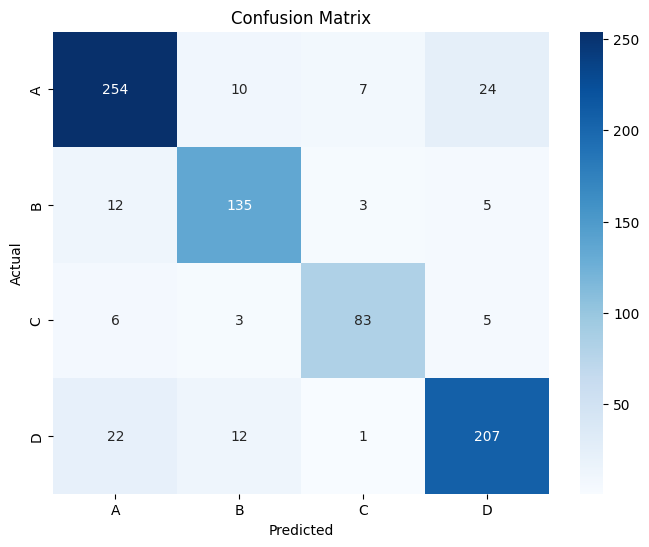

Classification Report:
              precision    recall  f1-score   support

           A       0.86      0.86      0.86       295
           B       0.84      0.87      0.86       155
           C       0.88      0.86      0.87        97
           D       0.86      0.86      0.86       242

    accuracy                           0.86       789
   macro avg       0.86      0.86      0.86       789
weighted avg       0.86      0.86      0.86       789



In [105]:
n_estimators = 1000
rf_classifier = Random_Forest_Classifier(n_estimators=n_estimators, random_state=42)
rf_classifier.fit(X_train.values, y_train.values)
yhat_test = rf_classifier.predict(X_test.values)

accuracy = accuracy_score(y_pred_rf, yhat_test)
# predictions_df = pd.DataFrame(data={'predicted': yhat_test})
# predictions_df.to_csv('rf.csv', index=False)
# print(f"Predictions saved to 'rf.csv'.")
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(y_pred_rf, yhat_test)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
labels = np.unique(yhat_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate and display the classification report (precision, recall, F1-score)
report = classification_report(y_pred_rf, yhat_test) #, target_names=y_pred_ovo.unique()) #unique_classes)
print("Classification Report:")
print(report)